In [196]:
#
# Integrated gradients for attributing neural network prediction
#

In [1]:
# Bear from wikimedia (cf. https://commons.wikimedia.org/wiki/Category:Animalia#/media/File:2010-kodiak-bear-1.jpg)
!wget -c -P ../data https://upload.wikimedia.org/wikipedia/commons/7/71/2010-kodiak-bear-1.jpg

# ImageNetLabels (cf. https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/4)
!wget -c -P ../data https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

--2020-07-09 18:46:33--  https://upload.wikimedia.org/wikipedia/commons/7/71/2010-kodiak-bear-1.jpg
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2020-07-09 18:46:34--  https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.175.240, 216.58.220.112, 172.217.175.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.175.240|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is already fully retrieved; nothing to do.



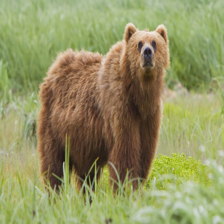

In [2]:
import PIL.Image

ex = PIL.Image.open('../data/2010-kodiak-bear-1.jpg')
ex = ex.resize([224, 224])
ex

In [3]:
#
# MobileNetV2 from torchvision
#
import torch
import torchvision

model = torchvision.models.mobilenet_v2(pretrained=True)
model.eval()

# cf. https://pytorch.org/docs/master/torchvision/models.html#classification
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# labels
image_net_labels = open('../data/ImageNetLabels.txt').read().split('\n')[1:]

In [4]:
import numpy as np

#
#  Predict bear
#
x = np.array(ex)
x = x.astype(np.float32) / 255
x = torch.tensor(x)
x = x.transpose(1, 2).transpose(0, 1)
x = normalize(x)
x = x[None, ...]
y = model(x)[0]
z = torch.topk(torch.softmax(y, 0), 8)
z, [image_net_labels[i] for i in z.indices]

(torch.return_types.topk(
 values=tensor([9.9849e-01, 7.2960e-04, 4.0573e-04, 7.6665e-05, 5.0541e-05, 4.7863e-05,
         4.5879e-05, 2.9602e-05], grad_fn=<TopkBackward>),
 indices=tensor([294, 295, 297, 337, 106, 362, 260, 336])),
 ['brown bear',
  'American black bear',
  'sloth bear',
  'beaver',
  'wombat',
  'badger',
  'chow',
  'marmot'])

In [5]:
#
# Integrated gradients
#

def integrated_gradients(f, x1, x0, n):
    g = torch.zeros_like(x0)
    for i in range(n):
        t = (0.5 + i) / n
        x = (x0 + t * (x1 - x0)).detach_().requires_grad_()
        y = f(x)
        y.backward()
        g += x.grad
    g /= n
    g *= (x1 - x0)
    return g

In [21]:
idx = torch.argmax(y)
x1 = torch.tensor(np.array(ex, dtype=np.float32) / 255)
x0 = torch.zeros_like(x1)

def f(x):
    x = x.transpose(1, 2).transpose(0, 1)
    x = normalize(x)
    x = x[None, ...]
    y = model(x)
    y = y[0, idx]
    return y

f(x1), f(x0)

(tensor(20.9484, grad_fn=<SelectBackward>),
 tensor(-0.4777, grad_fn=<SelectBackward>))

In [17]:
g = integrated_gradients(f, x1, x0, 128)
torch.std_mean(g), torch.min(g), torch.max(g)

((tensor(0.0674), tensor(0.0001)), tensor(-1.3688), tensor(1.2672))

In [19]:
f(x1) - f(x0), g.sum()

(tensor(21.4260, grad_fn=<SubBackward0>), tensor(21.1174))

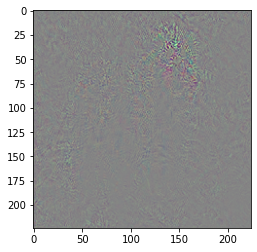

In [29]:
import matplotlib.pyplot as plt

m0, m1 = torch.min(g), torch.max(g)
h = (g - m0) / (m1 - m0)
plt.imshow(np.array(h))

In [34]:
#
# UMAP
#

import numpy as np

x = np.fromfile('../data/mnist/t10k-images-idx3-ubyte', np.uint8, offset=16)
y = np.fromfile('../data/mnist/t10k-labels-idx1-ubyte', np.uint8, offset=8)

x = x.reshape((-1, 28 * 28))
x = x.astype(np.float32) / 255

assert x.shape == (10000, 28 * 28)
assert y.shape == (10000,) 

In [43]:
import umap

umap_instance = umap.UMAP()
umap_instance.verbose = True
umap_instance.init = 'random'
umap_instance.n_epochs = 200

In [44]:
umap_instance.fit(x)

UMAP(init='random', n_epochs=200, verbose=True)
Construct fuzzy simplicial set
Thu Jul  9 10:40:01 2020 Finding Nearest Neighbors
Thu Jul  9 10:40:01 2020 Building RP forest with 10 trees
Thu Jul  9 10:40:01 2020 NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	 7  /  13
Thu Jul  9 10:40:04 2020 Finished Nearest Neighbor Search
Thu Jul  9 10:40:05 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Thu Jul  9 10:40:10 2020 Finished embedding


UMAP(init='random', n_epochs=200, verbose=True)

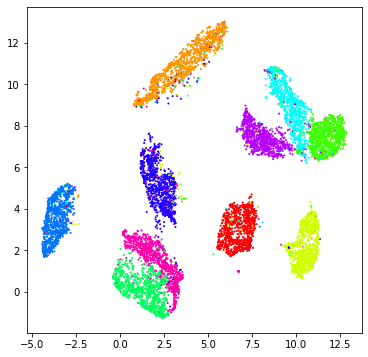

In [46]:
import matplotlib.pyplot as plt

e = umap_instance.embedding_
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(e[:, 0], e[:, 1], c=y/10, s=1, cmap='hsv', vmin=0, vmax=1)

In [1]:
#
# Numba/Python multithreading
#

import numpy as np
import numba

def f1(x, y, z):
    n = x.shape[0]
    for i in numba.prange(n):
        z[i] = x[i] + y[i]

def f2(x, y, z):
    z[:] = x + y
    
f3 = numba.njit(["void(float32[:], float32[:], float32[:])"], parallel=False, nogil=True)(f1)
f4 = numba.njit(["void(float32[:], float32[:], float32[:])"], parallel=True, nogil=True)(f1)

In [2]:
numba.threading_layer(), numba.get_num_threads()

('tbb', 4)

In [3]:
n = 2**25
x = np.arange(n, dtype=np.float32)
z = np.empty_like(x)

f3(x, x, z)
f4(x, x, z)

In [4]:
%timeit -n 10 -r 2 f3(x, x, z)

29.3 ms ± 1.51 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [12]:
%timeit -n 10 -r 2 f4(x, x, z)

27.4 ms ± 1.17 ms per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [6]:
import concurrent.futures

def make_chunks(n, num_chunks):
    chunk_size = n // num_chunks
    chunks = [[i * chunk_size, (i + 1) * chunk_size] for i in range(num_chunks)]    
    return chunks

k = 4
executer = concurrent.futures.ThreadPoolExecutor(max_workers=k)
chunks = make_chunks(n, k)

def run_chunk(se):
    s, e = se
    f3(x[s:e], x[s:e], z[s:e])
    
list(executer.map(run_chunk, chunks))

[None, None, None, None]

In [8]:
import threading

def run_threads():
    threads = []
    for [s, e] in chunks:
        t = threading.Thread(target=f3, args=(x[s:e], x[s:e], z[s:e]))
        threads.append(t)

    for t in threads:
        t.start()
        
    for t in threads:
        t.join()
        
run_threads()        

In [13]:
%timeit -n 10 -r 2 list(executer.map(run_chunk, chunks))

26.8 ms ± 936 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)


In [11]:
%timeit -n 10 -r 2 run_threads()

24.5 ms ± 833 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
